# Statistical Analysis Notebook

I have set up this Jupyter Notebook to perform statistical analysis on a dataset. This includes basic data exploration, statistical tests, and visualizations. But I also aim for regression analyses and calculation of marginal effects.


Jupyter Notebook in PyCharm Helpfile [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).

We start with importing the necessary libraries.

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical models and tests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Scikit-learn for ML-style modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# For statistical tests
from scipy import stats

## 1. EDA Summary Function
This function will provide a summary of the dataset, including basic statistics and datatypes.

In [8]:
def eda_summary(df):
    print("Shape:", df.shape)
    display(df.info())  ## specifically for Jupyter to display DataFrame info
    display(df.describe(include='all'))
    print("\nMissing values:\n", df.isnull().sum())
    print("\nData types:\n", df.dtypes)
    print("First 5 observations: ", df.head())
    print("Last 5 observations: ", df.tail())

We will use the `auto` dataset for our analysis. This dataset is commonly used for regression analysis and contains various attributes of automobiles.

In [6]:
auto = pd.read_csv('data/auto.csv')

In [9]:
eda_summary(auto)

Shape: (74, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   make          74 non-null     object 
 1   price         74 non-null     int64  
 2   mpg           74 non-null     int64  
 3   rep78         69 non-null     float64
 4   headroom      74 non-null     float64
 5   trunk         74 non-null     int64  
 6   weight        74 non-null     int64  
 7   length        74 non-null     int64  
 8   turn          74 non-null     int64  
 9   displacement  74 non-null     int64  
 10  gear_ratio    74 non-null     float64
 11  foreign       74 non-null     object 
dtypes: float64(3), int64(7), object(2)
memory usage: 7.1+ KB


None

,make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign
count,74,74.000000,74.000000,69.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74
unique,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,AMC Concord,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52
mean,NaN,6165.256757,21.297297,3.405797,2.993243,13.756757,3019.459459,187.932432,39.648649,197.297297,3.014865,NaN
std,NaN,2949.495885,5.785503,0.989932,0.845995,4.277404,777.193567,22.266340,4.399354,91.837219,0.456287,NaN
min,NaN,3291.000000,12.000000,1.000000,1.500000,5.000000,1760.000000,142.000000,31.000000,79.000000,2.190000,NaN
25%,NaN,4220.250000,18.000000,3.000000,2.500000,10.250000,2250.000000,170.000000,36.000000,119.000000,2.730000,NaN
50%,NaN,5006.500000,20.000000,3.000000,3.000000,14.000000,3190.000000,192.500000,40.000000,196.000000,2.955000,NaN
75%,NaN,6332.250000,24.750000,4.000000,3.500000,16.750000,3600.000000,203.750000,43.000000,245.250000,3.352500,NaN



Missing values:
 make            0
price           0
mpg             0
rep78           5
headroom        0
trunk           0
weight          0
length          0
turn            0
displacement    0
gear_ratio      0
foreign         0
dtype: int64

Data types:
 make             object
price             int64
mpg               int64
rep78           float64
headroom        float64
trunk             int64
weight            int64
length            int64
turn              int64
displacement      int64
gear_ratio      float64
foreign          object
dtype: object
First 5 observations:              make  price  mpg  rep78  headroom  trunk  weight  length  turn  \
0    AMC Concord   4099   22    3.0       2.5     11    2930     186    40   
1      AMC Pacer   4749   17    3.0       3.0     11    3350     173    40   
2     AMC Spirit   3799   22    NaN       3.0     12    2640     168    35   
3  Buick Century   4816   20    3.0       4.5     16    3250     196    40   
4  Buick Electra   7827 

## 2. Cross-tab & Grouped Stats
These functions can be used for simple crosstabs and grouped statistics.

In [24]:
def cross_tab(df, var1, var2, normalize=False):
    return pd.crosstab(df[var1], df[var2], normalize=normalize, margins=True)

def group_means(df, group_col, target_col):
    return df.groupby(group_col)[target_col].mean().sort_values(ascending=False)


In [26]:
cross_tab(auto, 'rep78', 'foreign', normalize=False)

foreign,Domestic,Foreign,All
rep78,,,
1.0,2,0,2
2.0,8,0,8
3.0,27,3,30
4.0,9,9,18
5.0,2,9,11
All,48,21,69


In [28]:
group_means(auto, 'foreign', 'mpg')

foreign
Foreign     24.772727
Domestic    19.826923
Name: mpg, dtype: float64

## 3. Statistical Tests

In [29]:
def run_ttest(df, group_col, value_col):
    groups = df[group_col].unique()
    assert len(groups) == 2, "T-test requires exactly 2 groups."
    g1 = df[df[group_col] == groups[0]][value_col]
    g2 = df[df[group_col] == groups[1]][value_col]
    t, p = stats.ttest_ind(g1, g2)
    print(f"T = {t:.3f}, p = {p:.3f}")
    return t, p

def run_chi2(df, col1, col2):
    table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, ex = stats.chi2_contingency(table)
    print(f"Chi² = {chi2:.3f}, p = {p:.3f}")
    return chi2, p

In [32]:
run_ttest(auto, 'foreign', 'mpg')

T = -3.631, p = 0.001


(-3.6308484477318377, 0.0005254159338341992)

In [33]:
run_chi2(auto, 'foreign', 'rep78')

Chi² = 27.264, p = 0.000


(27.263961038961035, 1.7579608426567363e-05)

## 4. Regression Wrappers
Note that for this to work, scipy needs to be version 1.15.3 or less.

In [34]:
# Linear Regression
def run_linear_regression(df, formula):
    model = smf.ols(formula, data=df).fit()
    display(model.summary())
    return model

# Logistic Regression
def run_logistic_regression(df, formula):
    model = smf.logit(formula, data=df).fit()
    display(model.summary())

    marg_eff = model.get_margeff()
    print("\nMarginal Effects:")
    display(marg_eff.summary())

    return model, marg_eff


Making sure that no missing values are present in the dataset before running the regression.

In [37]:
auto_reduced = auto.dropna()
auto_reduced.shape

(69, 12)

In [41]:
auto_reduced

,make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign
0,AMC Concord,4099,22,3.0,2.5,11,2930,186,40,121,3.58,Domestic
1,AMC Pacer,4749,17,3.0,3.0,11,3350,173,40,258,2.53,Domestic
3,Buick Century,4816,20,3.0,4.5,16,3250,196,40,196,2.93,Domestic
4,Buick Electra,7827,15,4.0,4.0,20,4080,222,43,350,2.41,Domestic
5,Buick LeSabre,5788,18,3.0,4.0,21,3670,218,43,231,2.73,Domestic
...,...,...,...,...,...,...,...,...,...,...,...,...
69,VW Dasher,7140,23,4.0,2.5,12,2160,172,36,97,3.74,Foreign
70,VW Diesel,5397,41,5.0,3.0,15,2040,155,35,90,3.78,Foreign
71,VW Rabbit,4697,25,4.0,3.0,15,1930,155,35,89,3.78,Foreign
72,VW Scirocco,6850,25,4.0,2.0,16,1990,156,36,97,3.78,Foreign


We encode foreign as a dummy variable for regression analysis.

In [47]:
def one_hot_encode(df, column):
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True, dtype=int)
    df = pd.concat([df, dummies], axis=1)
    return df.drop(column, axis=1)

In [48]:
auto_reduced_encoded = one_hot_encode(auto_reduced, 'foreign')

In [49]:
run_linear_regression(auto_reduced_encoded, formula='mpg ~ rep78 + foreign_Foreign')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     10.05
Date:                Fri, 04 Jul 2025   Prob (F-statistic):           0.000155
Time:                        17:21:02   Log-Likelihood:                -210.31
No. Observations:                  69   AIC:                             426.6
Df Residuals:                      66   BIC:                             433.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          15.8590      2.510      6.319      0.000      10.848      20.870
rep78               1.2191      0.793      1.538      0.129      -0.363       2.802
foreign_Foreign     4.2020      1.693      2.482      0.016       0.822       7.582
==============================================================================
Omnibus:                        3.936   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                3.327
Skew:                           0.532   Prob(JB):                        0.190
Kurtosis:                       3.161   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
run_logistic_regression(auto_reduced_encoded, formula='foreign_Foreign ~ rep78 + mpg')

Optimization terminated successfully.
         Current function value: 0.374662
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        foreign_Foreign   No. Observations:                   69
Model:                          Logit   Df Residuals:                       66
Method:                           MLE   Df Model:                            2
Date:                Fri, 04 Jul 2025   Pseudo R-squ.:                  0.3903
Time:                        17:21:18   Log-Likelihood:                -25.852
converged:                       True   LL-Null:                       -42.401
Covariance Type:            nonrobust   LLR p-value:                 6.499e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.0378      2.407     -4.169      0.000     -14.756      -5.319
rep78          1.7361      0.493      3.522      0.000       0.770       2.702
mpg            0.1329      0.074      1.806      0.071      -0.011       0.277
==============================================================================
"""


Marginal Effects:


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:        foreign_Foreign
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
rep78          0.2045      0.036      5.746      0.000       0.135       0.274
mpg            0.0156      0.008      1.956      0.050    -3.3e-05       0.031
==============================================================================
"""

(<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x18931b96150>,
 <statsmodels.discrete.discrete_margins.DiscreteMargins at 0x18931b77650>)

##  5. Correlation Matrix

In [53]:
def plot_correlation_matrix(df, method='pearson'):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    corr = numeric_df.corr(method=method)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(f"{method.title()} Correlation Matrix")
    plt.show()


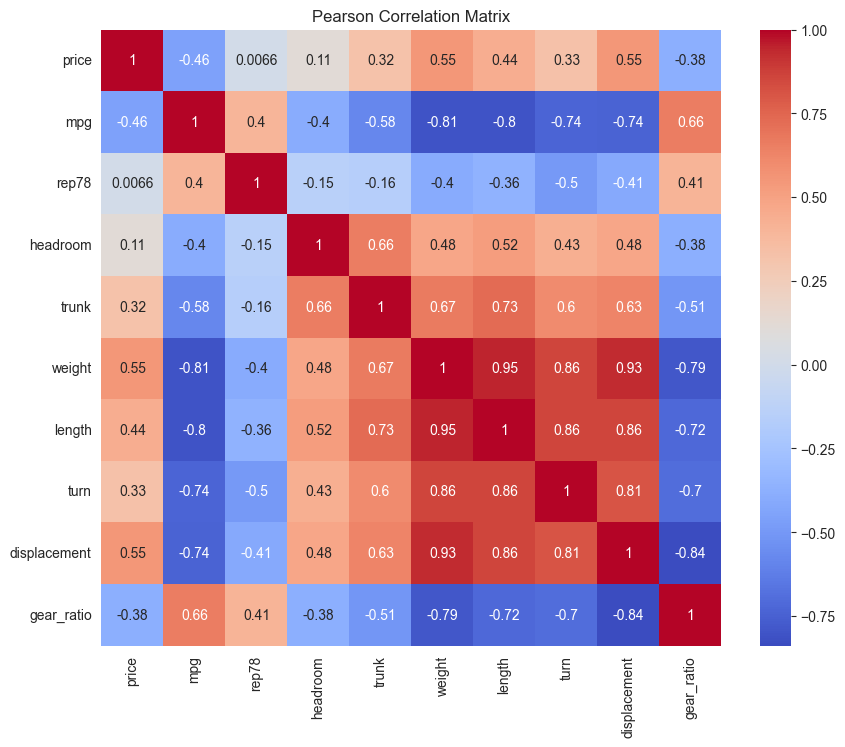

In [54]:
plot_correlation_matrix(auto_reduced_encoded)

## 6. Train-Test Split Helper

In [55]:
def train_test_split_df(df, target, test_size=0.3, random_state=42):
    X = df.drop(columns=[target])
    y = df[target]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


## 7. Boxplot Identifying Outliers

This function will create a boxplot for a specified column and automatically identify outliers based on the IQR method.

In [58]:
def plot_outliers(df, column):
    # Calculate IQR and bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

    # Create vertical boxplot
    plt.figure(figsize=(6, 10))
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column} with Outliers')

    # Print outlier information
    print(f"\nOutliers ({len(outliers)} found):")
    print(f"Lower bound: {lower_bound:.2f}")
    print(f"Upper bound: {upper_bound:.2f}")
    if len(outliers) > 0:
        print("\nOutlier values:")
        print(outliers.sort_values())

    plt.show()
    return outliers


Outliers (4 found):
Lower bound: 9.00
Upper bound: 33.00

Outlier values:
42    34
56    35
65    35
70    41
Name: mpg, dtype: int64


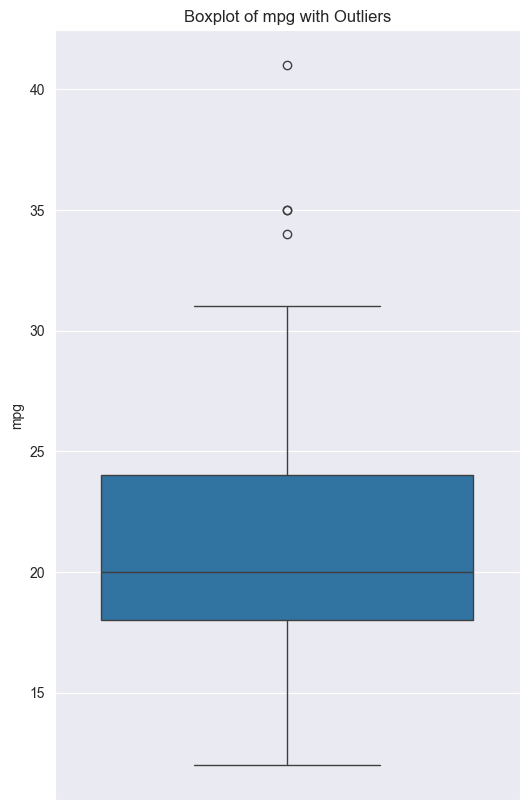

42    34
56    35
65    35
70    41
Name: mpg, dtype: int64

In [59]:
plot_outliers(auto_reduced_encoded, 'mpg')

## Histogram with KDE and Normal Distribution Overlay
This function will create a histogram with a Kernel Density Estimate (KDE) overlay and a normal distribution curve (both optional).

In [60]:
def plot_distribution(df, column, kde=True, normal=True, bins=30):
    # Setup the plot
    plt.figure(figsize=(10, 6))

    # Plot histogram with KDE
    sns.histplot(data=df, x=column, stat='density', bins=bins, kde=kde)

    # Add normal distribution curve if requested
    if normal:
        # Calculate normal distribution parameters
        mean = df[column].mean()
        std = df[column].std()
        xmin, xmax = plt.gca().get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mean, std)
        plt.plot(x, p, 'r--', linewidth=2, label='Normal Distribution')
        plt.legend()

    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

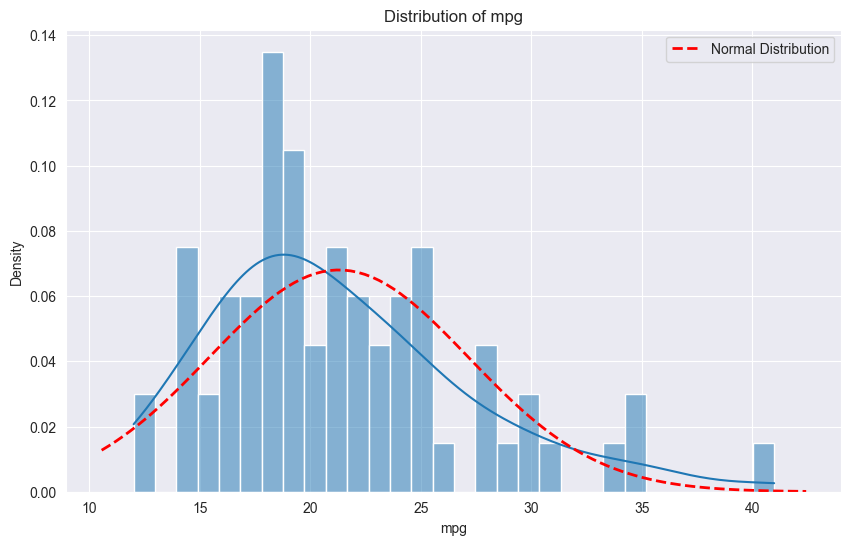

In [61]:
plot_distribution(auto_reduced_encoded, 'mpg')